In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns # for plotting
import scipy.cluster.hierarchy as shc # for dendrogram
import sklearn.preprocessing as skpp
import matplotlib.cm as cm # colormap
import re # reg expression

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import DistanceMetric
from scipy.spatial.distance import pdist,squareform

from tqdm import tqdm


In [2]:
raw_data = pd.read_csv('/Users/iMotz/Propulsion/Machine_learning/data_sets/df_prot+protocol.csv', sep = '\t') # tab

raw_data.head(5)


,patch_hyd,patch_hyd_1,patch_hyd_2,patch_hyd_3,patch_hyd_4,patch_hyd_5,patch_hyd_n,patch_pos,patch_pos_1,patch_pos_2,...,edta_values,mes_values,lithium_values,code,sodium_value,calcium_values,magnesium_values,potassium_values,solvents,buffers
0,280.0,280.0,280.0,280.0,280.0,280.0,1.0,590.0,100.0,190.0,...,EDTA,NaN,NaN,101M,NaN,NaN,NaN,NaN,NaN,TRIS
1,210.0,160.0,210.0,210.0,210.0,210.0,2.0,840.0,110.0,210.0,...,NaN,NaN,NaN,102L,NaN,NaN,NaN,NaN,NaN,NaN
2,280.0,280.0,280.0,280.0,280.0,280.0,1.0,560.0,90.0,180.0,...,EDTA,NaN,NaN,102M,NaN,NaN,NaN,NaN,NaN,TRIS
3,330.0,160.0,220.0,280.0,330.0,330.0,4.0,860.0,120.0,230.0,...,NaN,NaN,NaN,103L,NaN,NaN,NaN,NaN,NaN,NaN
4,350.0,300.0,350.0,350.0,350.0,350.0,2.0,530.0,90.0,180.0,...,EDTA,NaN,NaN,103M,NaN,NaN,NaN,NaN,NaN,TRIS


In [3]:
raw_data.shape

(49104, 113)

In [4]:
raw_data['DTT_values'].unique()

array([    nan, 1.0e+04, 2.0e+03, 3.0e+00, 1.0e+03, 3.8e+03, 1.0e+00,
       5.0e+03, 2.0e+00, 4.0e+03, 5.0e+02, 9.0e+02, 7.0e+03, 2.0e+02,
       2.0e+04, 1.0e+02, 5.0e+00, 3.0e+03, 1.5e+03, 4.0e+02, 2.5e+03,
       1.5e+04, 4.0e+04, 5.0e+04, 2.0e+01, 1.0e+01, 2.5e+04, 0.0e+00,
       1.0e+05, 8.0e+02, 6.0e+03, 2.5e+02, 4.0e+01, 1.6e+04])

In [5]:
obj_col_names = raw_data.select_dtypes(['object']).columns
obj_col_names

Index(['exp_data', 'resolution_group', 'glycerol_values', 'ammonium_values',
       'edta_values', 'mes_values', 'lithium_values', 'code', 'sodium_value',
       'calcium_values', 'magnesium_values', 'potassium_values', 'solvents',
       'buffers'],
      dtype='object')

#### explore single columns, decide how to proceed

In [6]:
raw_data[['res','resolution_group']].groupby(obj_col_names[1]).median()

,res
resolution_group,
-0.49992803427388566,NaN
medium,2.27
strong,1.69
weak,3.20


### Convert categorial to boolean

In [7]:
raw_cat_data = raw_data.select_dtypes(['object'])
raw_cat_data = raw_cat_data.drop(columns = 'code')
raw_cat_data.head()


,exp_data,resolution_group,glycerol_values,ammonium_values,edta_values,mes_values,lithium_values,sodium_value,calcium_values,magnesium_values,potassium_values,solvents,buffers
0,X-RAY DIFFRACTION,medium,NaN,AMMONIUM SULPHATE,EDTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRIS
1,X-RAY DIFFRACTION,strong,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,X-RAY DIFFRACTION,strong,NaN,AMMONIUM SULPHATE,EDTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRIS
3,X-RAY DIFFRACTION,strong,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,X-RAY DIFFRACTION,medium,NaN,AMMONIUM SULPHATE,EDTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRIS


In [8]:
# do not create columns for NaNs
bool_data = pd.get_dummies(raw_cat_data, dummy_na = False)
bool_data.head()


,exp_data_ELECTRON CRYSTALLOGRAPHY,exp_data_FIBER DIFFRACTION,exp_data_X-RAY DIFFRACTION,exp_data_X-RAY DIFFRACTION EPR,exp_data_X-RAY DIFFRACTION NEUTRON DIFFRACTION,exp_data_X-RAY DIFFRACTION SOLUTION NMR,resolution_group_-0.49992803427388566,resolution_group_medium,resolution_group_strong,resolution_group_weak,...,solvents_PROPANOL,buffers_BIS-TRIS,buffers_HEPES,buffers_HEPES TRIS,buffers_HEPES BIS-TRIS,buffers_HEPES TRIS-HCL,buffers_HEPES TRIS-HCL BIS-TRIS,buffers_TRIS,buffers_TRIS-HCL,buffers_TRIS-HCL BIS-TRIS
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
# delete columns with less than 100 ones, or 
bool_col_names = bool_data.columns
bool_data_clean = bool_data.copy()

for col in bool_col_names:
    curr_sum = np.sum(bool_data_clean[col], axis = 0)
    if curr_sum < 100 or curr_sum > len(bool_data)-100:
        print('Deleting column %s' % col)
        bool_data_clean.drop(columns = col, inplace = True)


Deleting column exp_data_ELECTRON CRYSTALLOGRAPHY
Deleting column exp_data_FIBER DIFFRACTION
Deleting column exp_data_X-RAY DIFFRACTION
Deleting column exp_data_X-RAY DIFFRACTION EPR
Deleting column exp_data_X-RAY DIFFRACTION NEUTRON DIFFRACTION
Deleting column exp_data_X-RAY DIFFRACTION SOLUTION NMR
Deleting column resolution_group_-0.49992803427388566
Deleting column lithium_values_LITHIUM ACETATE
Deleting column lithium_values_LITHIUM CITRATE
Deleting column sodium_value_SODIUM AZIDE
Deleting column sodium_value_SODIUM AZIDESODIUM CHLORIDE
Deleting column sodium_value_SODIUM BROMIDE
Deleting column sodium_value_SODIUM CACODYLATESODIUM CHLORIDE
Deleting column sodium_value_SODIUM CHLORIDESODIUM CHLORIDE
Deleting column sodium_value_SODIUM FLUORIDE
Deleting column sodium_value_SODIUM FLUORIDESODIUM CHLORIDE
Deleting column sodium_value_SODIUM FORMATESODIUM CHLORIDE
Deleting column sodium_value_SODIUM HEPES
Deleting column sodium_value_SODIUM IODIDE
Deleting column sodium_value_SODIUM 

#### Check for corr features

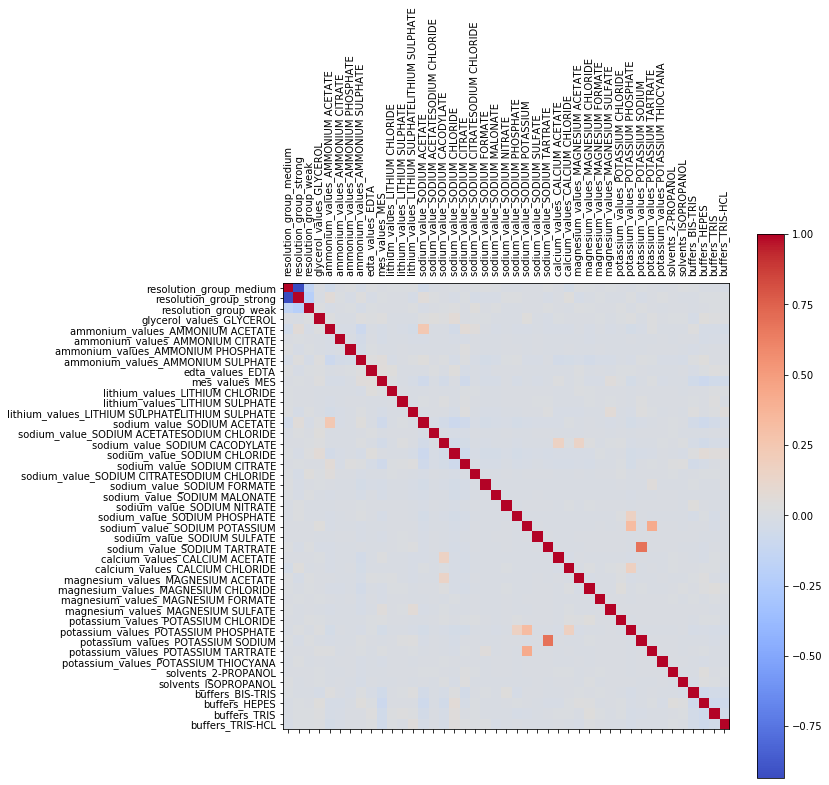

In [10]:
corr_bool = bool_data_clean.corr()

# print smaller as heatmap
feature_names = list(corr_bool)

plt.figure(figsize=(10, 10)) 
plt.imshow(corr_bool, cmap = 'coolwarm') # interpolation = 'nearest'
plt.tick_params(labeltop = 1, labelbottom = 0)
plt.xticks(range(len(feature_names)), feature_names, rotation = 90)
plt.yticks(range(len(feature_names)), feature_names)
plt.colorbar()
None

In [11]:
# loops over features and compares 1 by all other, every relation only ONCE
corr_threshold = [0.8]

correlated_bool_features = []
for i in range(len(corr_bool.columns)):
    for j in range(i):
        if abs(corr_bool.iloc[i, j]) > corr_threshold:
           correlated_bool_features.append(corr_bool.columns[i])
            
bool_cols_to_remove = list(set(correlated_bool_features))
bool_cols_to_remove

['resolution_group_strong']

In [12]:
bool_data_clean = bool_data_clean.drop(columns = bool_cols_to_remove)

bool_data_clean.shape

(49104, 42)

### Normalize numerical data

In [13]:
num_raw_data = raw_data.select_dtypes(['float64'])

In [14]:
num_raw_data.shape

(49104, 99)

In [15]:
num_data = skpp.StandardScaler().fit_transform(num_raw_data)
num_data = pd.DataFrame(num_data, columns = num_raw_data.columns)
num_data.head()

,patch_hyd,patch_hyd_1,patch_hyd_2,patch_hyd_3,patch_hyd_4,patch_hyd_5,patch_hyd_n,patch_pos,patch_pos_1,patch_pos_2,...,res_ASA_mean,res_charge_mean,propKa_mean,matthews_coeff,pH,solvent_content,temperature,res,DTT_values,peg_values
0,-0.718602,0.010875,-0.189329,-0.323297,-0.425537,-0.506109,-1.494999,-0.497447,-0.569154,-0.467281,...,-1.0,1.0,1.0,0.735447,1.728256,0.994828,NaN,0.225936,NaN,NaN
1,-0.806535,-0.188336,-0.298043,-0.429234,-0.529682,-0.608825,-1.288017,0.037799,-0.433171,-0.273883,...,-1.0,1.0,1.0,0.230233,NaN,0.512774,NaN,-0.440471,NaN,NaN
2,-0.718602,0.010875,-0.189329,-0.323297,-0.425537,-0.506109,-1.494999,-0.561676,-0.705138,-0.563980,...,-1.0,1.0,1.0,0.735447,1.728256,0.994828,NaN,-0.238529,NaN,NaN
3,-0.655793,-0.188336,-0.282513,-0.323297,-0.351148,-0.432740,-0.874054,0.080619,-0.297187,-0.080484,...,-1.0,1.0,1.0,0.155937,NaN,0.432432,NaN,-0.117364,NaN,NaN
4,-0.630669,0.044076,-0.080615,-0.217361,-0.321392,-0.403392,-1.288017,-0.625906,-0.705138,-0.563980,...,-1.0,1.0,1.0,0.735447,1.728256,1.004626,NaN,0.225936,NaN,NaN


#### Drop cols with many NaNs

In [16]:
np.sum(num_data.isna())

patch_hyd              1
patch_hyd_1            1
patch_hyd_2            1
patch_hyd_3            1
patch_hyd_4            1
patch_hyd_5            1
patch_hyd_n            1
patch_pos              1
patch_pos_1            1
patch_pos_2            1
patch_pos_3            1
patch_pos_4            1
patch_pos_5            1
patch_pos_n            1
patch_neg              1
patch_neg_1            1
patch_neg_2            1
patch_neg_3            1
patch_neg_4            1
patch_neg_5            1
patch_neg_n            1
patch_ion              1
patch_ion_1            1
patch_ion_2            1
patch_ion_3            1
patch_ion_4            1
patch_ion_5            1
patch_ion_n            1
patch_cdr_hyd          1
patch_cdr_hyd_1        1
                   ...  
asa_vdw                1
asa_hyd                1
asa_hph                1
volume                 1
mobility               1
helicity               1
henry                  1
net_charge             1
app_charge             1


In [17]:
ix_to_drop =  np.sum(num_data.isna()) > 10
num_data = num_data.drop(columns = num_data.columns[ix_to_drop])


In [18]:
num_data.shape


(49104, 93)

#### Check for corr features

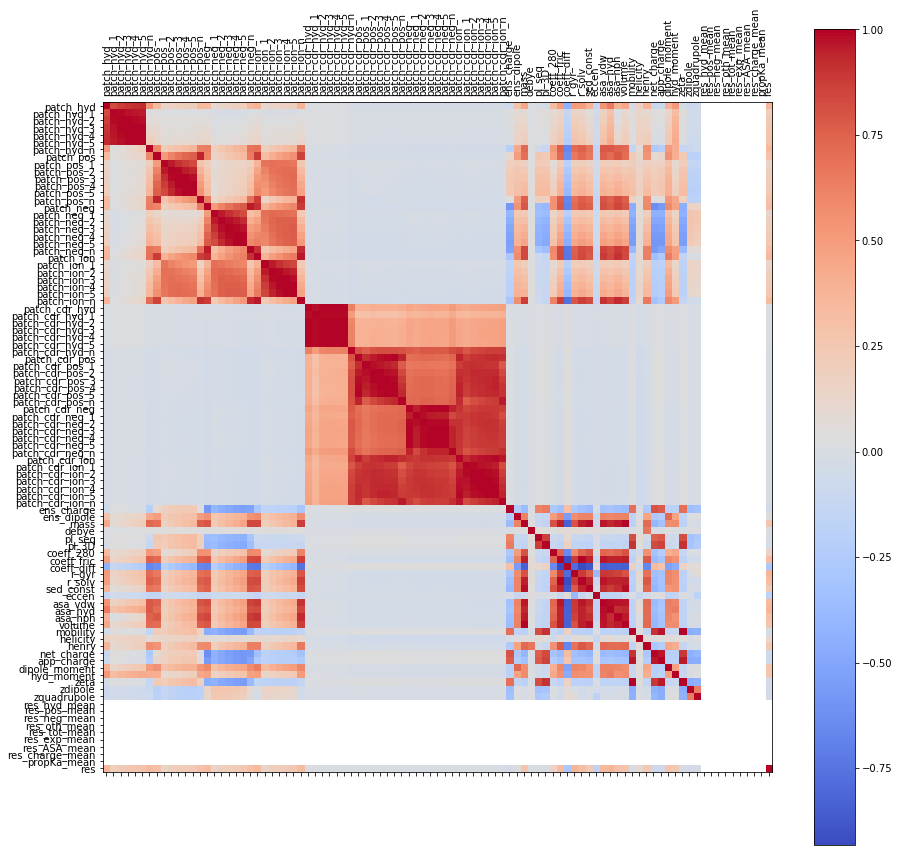

In [19]:
corr_num = num_data.corr()

# print smaller as heatmap
feature_names = list(corr_num)

plt.figure(figsize=(15, 15)) 
plt.imshow(corr_num, cmap = 'coolwarm') # interpolation = 'nearest'
plt.tick_params(labeltop = 1, labelbottom = 0)
plt.xticks(range(len(feature_names)), feature_names, rotation = 90)
plt.yticks(range(len(feature_names)), feature_names)
plt.colorbar()
None

In [20]:
# loops over features and compares 1 by all other, every relation only ONCE
corr_threshold = [0.8]

correlated_features = []
for i in range(len(corr_num.columns)):
    for j in range(i):
        if abs(corr_num.iloc[i, j]) > corr_threshold:
           correlated_features.append(corr_num.columns[i])
            
cols_to_remove = list(set(correlated_features))
cols_to_remove

['patch_neg_5',
 'patch_cdr_hyd_3',
 'app_charge',
 'patch_ion',
 'patch_pos_n',
 'asa_hph',
 'patch_cdr_pos_5',
 'patch_hyd_2',
 'patch_pos_2',
 'patch_cdr_ion_4',
 'patch_hyd_1',
 'patch_neg_n',
 'coeff_280',
 'patch_cdr_neg_n',
 'r_gyr',
 'patch_neg_4',
 'mass',
 'patch_cdr_ion_3',
 'patch_cdr_pos_4',
 'pI_3D',
 'patch_cdr_pos',
 'coeff_diff',
 'patch_cdr_neg_4',
 'patch_cdr_pos_3',
 'patch_ion_3',
 'patch_hyd_4',
 'r_solv',
 'patch_cdr_ion_5',
 'patch_cdr_ion_1',
 'patch_ion_4',
 'patch_pos_3',
 'asa_hyd',
 'net_charge',
 'patch_cdr_pos_1',
 'patch_neg_2',
 'patch_cdr_ion_n',
 'patch_pos_4',
 'patch_ion_n',
 'volume',
 'coeff_fric',
 'patch_cdr_hyd_4',
 'patch_ion_5',
 'patch_hyd_3',
 'patch_cdr_ion_2',
 'patch_hyd_5',
 'patch_cdr_pos_n',
 'zeta',
 'asa_vdw',
 'patch_cdr_hyd_5',
 'patch_cdr_neg_1',
 'patch_cdr_neg_2',
 'mobility',
 'sed_const',
 'patch_pos_5',
 'patch_ion_2',
 'patch_cdr_hyd_2',
 'patch_cdr_ion',
 'patch_neg_3',
 'patch_cdr_neg_3',
 'patch_cdr_hyd_1',
 'patch_cdr_p

In [21]:
num_data = num_data.drop(columns = cols_to_remove)


In [22]:
more_cols_remove = ['res_hyd_mean','res_pos_mean','res_neg_mean','res_oth_mean','res_tot_mean',
                    'res_exp_mean','res_ASA_mean','res_charge_mean','propKa_mean']
num_data = num_data.drop(columns = more_cols_remove)


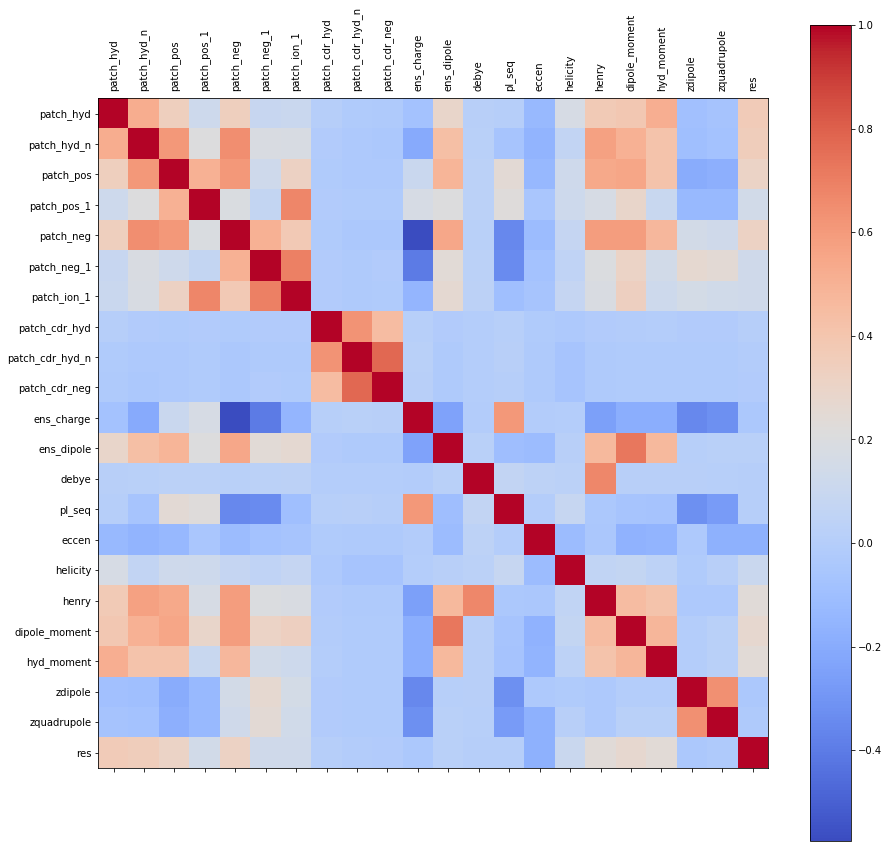

In [23]:
corr_num = num_data.corr()

# print smaller as heatmap
feature_names = list(corr_num)

plt.figure(figsize=(15, 15)) 
plt.imshow(corr_num, cmap = 'coolwarm') # interpolation = 'nearest'
plt.tick_params(labeltop = 1, labelbottom = 0)
plt.xticks(range(len(feature_names)), feature_names, rotation = 90)
plt.yticks(range(len(feature_names)), feature_names)
plt.colorbar()
None

In [24]:
num_data.shape

(49104, 22)

### Merge boolean and numerical data

In [25]:
data = pd.merge(bool_data_clean, num_data, left_index=True, right_index = True)

In [26]:
# check for rows with NaN
nan_ix = data.isna().any(axis=1)


In [27]:
data = data[~nan_ix]
data.shape

(49103, 64)

In [28]:
# remove same row from code
Code_ID = raw_data['code'].copy()
Code_ID = Code_ID[~nan_ix]
Code_ID.shape

(49103,)

## Goal 1: Cluster proteins and protocols together

### First, get distance matrix

#### Generate smaller data set

In [49]:
# random index
rand_ix = np.random.randint(0, data.shape[0], 5000)

data_small = data.iloc[rand_ix,:]
data_small.shape

(5000, 64)

In [50]:
# calculate distances for boolean and numerical data separately:

# get col names for cat and num data:
bool_col_names = bool_data_clean.columns
num_col_names = num_data.columns


In [51]:
dist_array_bool = pdist(data_small[bool_col_names], 'dice')

dist_mat_bool = squareform(dist_array_bool)


In [52]:
dist_array_num = pdist(data_small[num_col_names], 'cityblock') # = Manhattan

dist_mat_num = squareform(dist_array_num)

# norm between 0 and 1
dist_mat_num_norm = skpp.normalize(dist_mat_num)

In [53]:
# merge dist mats
dist_mat_mean = (dist_mat_num_norm + dist_mat_bool) / 2


### K-medoid clustering

In [54]:
import numpy as np
import random

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C


In [55]:
cluster_number = 4
M, C = kMedoids(dist_mat_mean, cluster_number)


In [56]:
# convert result into clusterID
Cluster_ID_medoid = [0 for x in range(0,len(dist_mat_mean))]

for i in range(cluster_number):
    curr_GI = list(C[i])
    for n in curr_GI:
        Cluster_ID_medoid[n] = i


### Hierarchical clustering of distance matrix: affinity=precomputed

! have NaNs in dist mat !

In [37]:
good_ix = np.isfinite(dist_mat_mean)


In [39]:
# dendro
#my_linkage = shc.linkage(dist_array_mean, method='average') 


In [43]:
# hier_clust = AgglomerativeClustering(n_clusters = 4, affinity = 'precomputed', linkage = 'complete').fit(dist_mat_mean)
# hier_clust_ID = hier_clust.labels_

# hier_clust_euc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward').fit(dist_mat_mean)
# hier_clust_euc_ID = hier_clust_euc.labels_


In [57]:
# add cluster ID to df, sort!
data_sorted_ID = data_small.copy() # copy of orig


#data_sorted_ID['Cluster_ID'] = hier_clust_ID # add col
#data_sorted_ID['Cluster_ID_euc'] = hier_clust_euc_ID
data_sorted_ID['Cluster_ID_medoid'] = Cluster_ID_medoid

data_sorted_ID = data_sorted_ID.sort_values('Cluster_ID_medoid', ascending = True).reset_index()
data_sorted_ID.head()
data_sorted = data_sorted_ID.drop(columns = ['Cluster_ID_medoid','index'])


### Heatmap of clusters

In [58]:
# convert cluster ID to color
data_sorted_ID['Cluster'] = 'aquamarine'
data_sorted_ID['Cluster'][data_sorted_ID['Cluster_ID_medoid'] == 1] = 'turquoise'
data_sorted_ID['Cluster'][data_sorted_ID['Cluster_ID_medoid'] == 2] = 'lightseagreen'
data_sorted_ID['Cluster'][data_sorted_ID['Cluster_ID_medoid'] == 3] = 'teal'


/Users/iMotz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/iMotz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/iMotz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


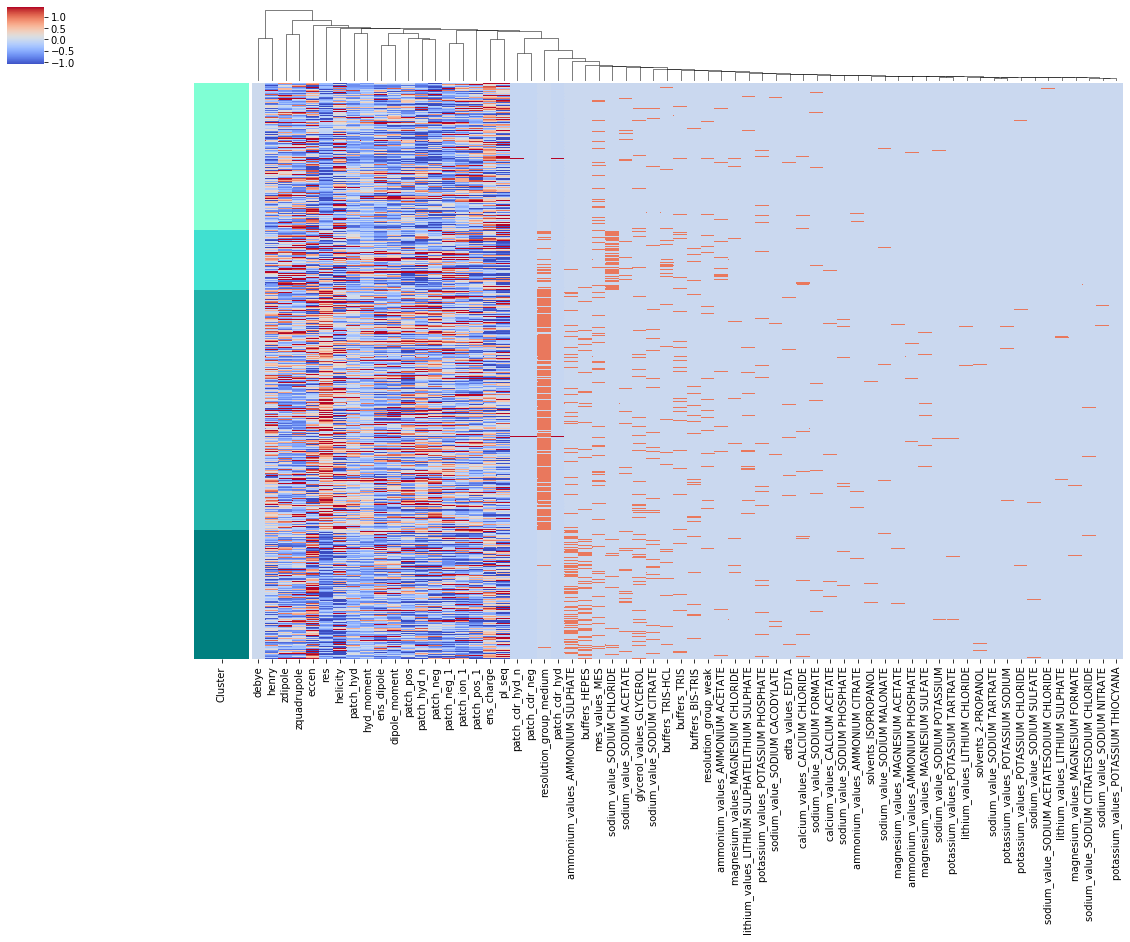

In [59]:
sns.clustermap(data_sorted, cmap = 'coolwarm', figsize = (20,12),
               row_cluster=False, col_cluster=True, # turns off clustering
               yticklabels=False, robust = True,
               row_colors = data_sorted_ID['Cluster']) # adds colors per cluster

None

In [62]:
# characterize clusters
mean_cluster_values = data_sorted_ID.groupby('Cluster_ID_medoid').mean()
mean_cluster_values = mean_cluster_values.drop(columns = ['index'])

median_cluster_values = data_sorted_ID.groupby('Cluster_ID_medoid').median()
median_cluster_values = median_cluster_values.drop(columns = ['index'])


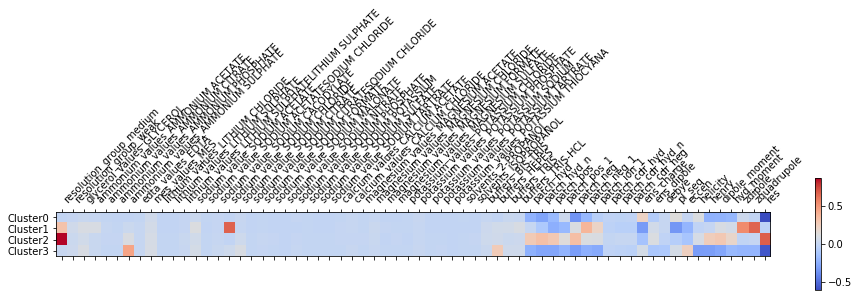

In [63]:
plt.matshow(mean_cluster_values, cmap='coolwarm')
plt.yticks([0,1,2,3],['Cluster0','Cluster1','Cluster2', 'Cluster3'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(mean_cluster_values.columns)), mean_cluster_values.columns, rotation = 45, ha='left')
None

### Result:

protein properties cluster with cristallization result (no wonder...)

**Cluster 0**: proteins crystallized with highest resolution, no particular buffer clusters

**Cluster 1**: proteins crystallized with medium resolution, 

**Cluster 2**: proteins crystallized with medium resolution, buffer contains Amm Sulfate

**Cluster 3**: proteins crystallized with low resolution, in MES buffer


## Goal 2: Cluster protein and protocols separately, compare

In [64]:
col_labels = data_small.columns

buffer_data = data_small.iloc[:,2:42] # all boolean
protein_data = data_small.iloc[:,42:].drop(columns = 'res') # all numerical

protein_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 36630 to 48936
Data columns (total 21 columns):
patch_hyd          5000 non-null float64
patch_hyd_n        5000 non-null float64
patch_pos          5000 non-null float64
patch_pos_1        5000 non-null float64
patch_neg          5000 non-null float64
patch_neg_1        5000 non-null float64
patch_ion_1        5000 non-null float64
patch_cdr_hyd      5000 non-null float64
patch_cdr_hyd_n    5000 non-null float64
patch_cdr_neg      5000 non-null float64
ens_charge         5000 non-null float64
ens_dipole         5000 non-null float64
debye              5000 non-null float64
pI_seq             5000 non-null float64
eccen              5000 non-null float64
helicity           5000 non-null float64
henry              5000 non-null float64
dipole_moment      5000 non-null float64
hyd_moment         5000 non-null float64
zdipole            5000 non-null float64
zquadrupole        5000 non-null float64
dtypes: float64(21)
memory 

### K-means of numerical data (protein)

#### Elbow plot to determine good k

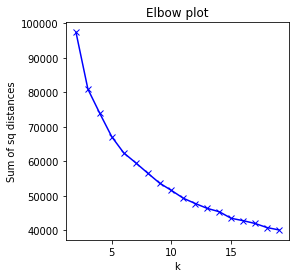

In [65]:
# loop over diff cluster numbers to find optimal k
Sum_of_squared_distances = []
for i in range(2,20):
    result_kmeans = KMeans(n_clusters = i).fit(protein_data)
    Sum_of_squared_distances.append(result_kmeans.inertia_)
        
# Plot the elbow
plt.rcParams['figure.figsize'] = (4, 4)
plt.plot(range(2,20), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of sq distances')
plt.title('Elbow plot')
None

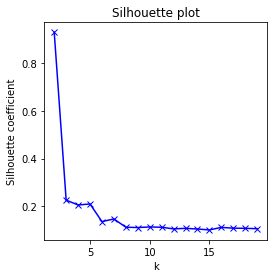

In [66]:
# loop over diff cluster numbers to find optimal silh score
silh_scores = []
for i in range(2,20):
    cluster_ids = KMeans(n_clusters = i).fit_predict(protein_data)
    silh_scores.append(silhouette_score(protein_data, cluster_ids)) 

plt.rcParams['figure.figsize'] = (4, 4)
plt.plot(range(2,20), silh_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette plot')
None

In [68]:
result_kmeans = KMeans(n_clusters = 5).fit(protein_data)

cluster_ID = result_kmeans.labels_


In [69]:
# add cluster ID to df, sort!
protein_data_sort_ID = protein_data.copy() # copy of orig

protein_data_sort_ID['Cluster_ID'] = cluster_ID # add col
protein_data_sort_ID = protein_data_sort_ID.sort_values('Cluster_ID', ascending = True).reset_index()

data_sorted = protein_data_sort_ID.drop(columns = ['Cluster_ID','index'])

Sankey_protein = protein_data_sort_ID.loc[:,['Cluster_ID','index']]
Sankey_protein.head(3)


,Cluster_ID,index
0,0,13778
1,0,23160
2,0,3484


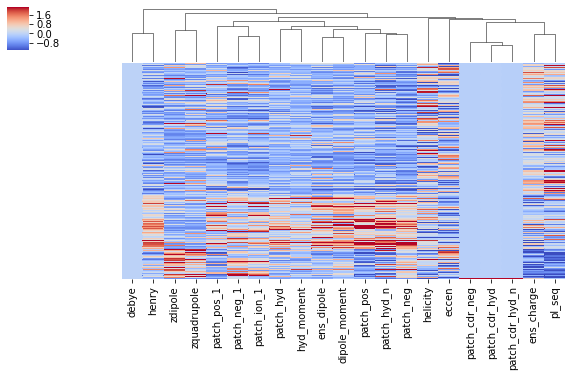

In [70]:
sns.clustermap(data_sorted, cmap = 'coolwarm', figsize = (10,5),
               row_cluster=False, col_cluster=True, # turns off clustering
               yticklabels=False, robust = True)
 #              row_colors = data_sorted_ID['Cluster']) # adds colors per cluster

None

### K-medoid of boolean data (buffers)


In [71]:
# get dist matrix

buffer_cols = buffer_data.columns
dist_array_bool = pdist(buffer_data[buffer_cols], 'dice')
dist_mat_bool = squareform(dist_array_bool)

# replace NaNs
dist_mat_bool_df = pd.DataFrame(data = dist_mat_bool)
dist_mat_bool_df.isna().sum()
# fill missing values with mean column values
dist_mat_bool_df.fillna(dist_mat_bool_df.mean(), inplace=True)


In [72]:
n_clust = 5
M, C = kMedoids(dist_mat_bool_df.values, n_clust)

# convert result into clusterID
Cluster_ID_medoid = [0 for x in range(0,len((dist_mat_bool_df.values)))]

for i in range(n_clust):
    curr_GI = list(C[i])
    for n in curr_GI:
        Cluster_ID_medoid[n] = i


In [73]:
# add cluster ID to df, sort!
buffer_data_sort_ID = buffer_data.copy() # copy of orig

buffer_data_sort_ID['Cluster_ID'] = Cluster_ID_medoid # add col
buffer_data_sort_ID = buffer_data_sort_ID.sort_values('Cluster_ID', ascending = True).reset_index()

data_sorted_buff = buffer_data_sort_ID.drop(columns = ['Cluster_ID','index'])

Sankey_buffer = buffer_data_sort_ID.loc[:,['Cluster_ID','index']]
Sankey_buffer.head(3)


,Cluster_ID,index
0,0,36630
1,0,30529
2,0,35459


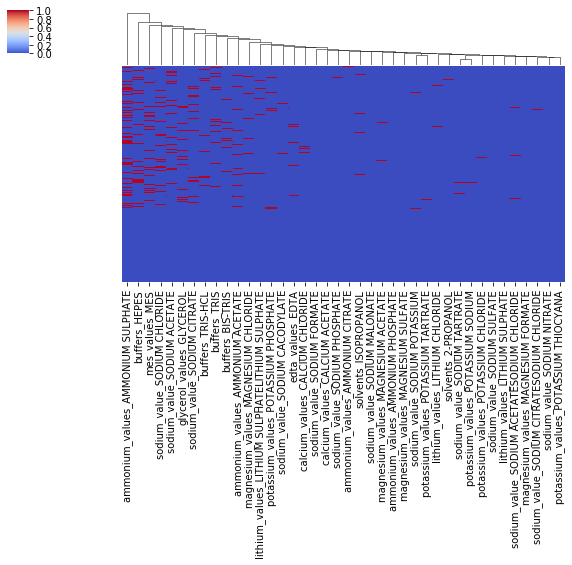

In [74]:
sns.clustermap(data_sorted_buff, cmap = 'coolwarm', figsize = (10,5),
               row_cluster=False, col_cluster=True, # turns off clustering
               yticklabels=False, robust = False)
 #              row_colors = data_sorted_ID['Cluster']) # adds colors per cluster

None

#### get values for Sankey

In [75]:
df_sankey = pd.merge(Sankey_protein, Sankey_buffer, left_on='index', right_on='index' )
df_sankey.head(5)

,Cluster_ID_x,index,Cluster_ID_y
0,0,13778,0
1,0,13778,0
2,0,13778,0
3,0,13778,0
4,0,23160,0


In [78]:
df_sankey_summary = pd.DataFrame(columns = ['SourceCluster','TargetCluster','Values'], data = [])
df_sankey_summary['SourceCluster'] = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4]
df_sankey_summary['TargetCluster'] = [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4]

value_list = []
for i in range(len(df_sankey_summary)):
    curr_source = df_sankey_summary['SourceCluster'][i]
    curr_targ = df_sankey_summary['TargetCluster'][i] 
    curr_result = np.sum((df_sankey['Cluster_ID_x'] == curr_source) & (df_sankey['Cluster_ID_y'] == curr_targ))
    value_list.append(curr_result)

df_sankey_summary['Values'] = value_list

# convert values into dictionary
my_links = []

for i in range(len(df_sankey_summary)):
    my_links.append({'source': 'Prot_Clust_'+ str(df_sankey_summary['SourceCluster'][i]), 
                     'target': 'Buff_Clust_'+ str(df_sankey_summary['TargetCluster'][i]), 
                     'value': df_sankey_summary['Values'][i]})      


In [79]:
from ipysankeywidget import SankeyWidget
# my_order = [ ['Prot_Clust_0','Prot_Clust_1','Prot_Clust_4','Prot_Clust_2','Prot_Clust_3','Prot_Clust_5'],
#          ['Buff_Clust_0', 'Buff_Clust_1','Buff_Clust_2','Buff_Clust_3','Buff_Clust_4','Buff_Clust_5']]


SankeyWidget(links = my_links,   margins=dict(top=10, bottom=0, left=100, right=100))

SankeyWidget(links=[{'source': 'Prot_Clust_0', 'target': 'Buff_Clust_0', 'value': 2257}, {'source': 'Prot_Clus…

## Goal 3: PCA on protein data